In [5]:
import torch

In [6]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w',encoding='utf-8') as f:
            f.write(text_data)
    else:
        with open(file_path, 'r',encoding='utf-8') as f:
            text_data = f.read()
    # 注释：返回文本数据
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = "https://github.com/MLNLP-World/LLMs-from-scratch-CN/tree/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)
print("Number fo entries:", len(data))

Number fo entries: 1100


In [7]:
print("Exmaple entry:\n", data[0])

Exmaple entry:
 {'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}


In [8]:
# Alpaca风格
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""
    )
    return instruction_text + input_text

In [9]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [10]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [11]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [12]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokkenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokkenizer.encode(full_text))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.encoded_texts[idx]

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [14]:
def custom_collect_draft_1(batch, pat_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch) # 此处+1是给pad_token预留的，所以下面在copy完后，就直接加一个pad_token
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pat_token_id] # 此处加的pad_token可以理解为原序列的结尾，是算在原序列里面的，下面的才是填充

        padded = (new_item + [pat_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [15]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]
batch = (inputs_1, inputs_2, inputs_3)
print(custom_collect_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [16]:
def custom_collect_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor      

In [17]:
inputs, targets = custom_collect_draft_2(batch)
print("Inputs:\n", inputs)
print("Targets:\n", targets)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [18]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [19]:
aa = torch.tensor([True, True])
torch.nonzero(aa).squeeze()

tensor([0, 1])

In [20]:
x = torch.tensor([[1, 0, 3,4],
                  [0, 2, 0,5]])

torch.nonzero(x).squeeze()

tensor([[0, 0],
        [0, 2],
        [0, 3],
        [1, 1],
        [1, 3]])

In [21]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [22]:
logits_1 = torch.tensor(
    [[-1.0,1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0,1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

probas = torch.nn.functional.softmax(logits_1, dim=-1)
print(probas)

print((torch.log(probas[0,0]) + torch.log(probas[1,1])) / 2.0)

tensor(1.1269)
tensor([[0.1192, 0.8808],
        [0.1192, 0.8808]])
tensor(-1.1269)


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
# 函数参数预填充
from functools import partial

custimized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [25]:
from torch.utils.data import DataLoader

num_workers = 0
batch_szie = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=True, num_workers=num_workers, drop_last=True)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=False, num_workers=num_workers, drop_last=False)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_szie, collate_fn=custimized_collate_fn, shuffle=False, num_workers=num_workers, drop_last=False)

In [26]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [27]:
# 定义模型
import torch
import torch.nn as nn

MODEL_CONFIG= {
    'vocab_size': 50257,
    'context_length': 1024,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.scale = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.scale * (x - mean) / torch.sqrt(var + self.eps) + self.shift
    
# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.scale = nn.Parameter(torch.ones(emb_dim))
#         self.shift = nn.Parameter(torch.zeros(emb_dim))
#         self.eps = 1e-5

#     def forward(self, x:torch.Tensor):
#         mean = x.mean(dim=-1, keepdim=True)
#         var = x.var(dim=-1, keepdim=True, unbiased=False)
#         x_norm = (x - mean) / torch.sqrt(var + self.eps)
#         return self.scale * x_norm + self.shift

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, n_heads, context_length, drop_rate, qkv_bias=False):
        super().__init__()
        assert emb_dim % n_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())
        self.W_q = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_k = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_v = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_o = nn.Linear(emb_dim, emb_dim)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        batch_size, seq_len, dim = x.shape
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        # 拆多头
        queries = queries.view(batch_size, seq_len, self.n_heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.n_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.n_heads, self.head_dim)
        # 调整位置
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        # 计算注意力分数
        att_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5
        att_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        att_weights = torch.softmax(att_scores, dim=-1)
        att_weights = self.dropout(att_weights)
        context_vec = att_weights @ values # shape (B,H,L,D)
        # 头调整回去
        context_vec = context_vec.transpose(1,2).contiguous().view(batch_size, seq_len, dim)
        out = self.W_o(context_vec)
        return out
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, emb_dim * 4)
        self.fc2 = nn.Linear(emb_dim * 4, emb_dim)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.att = MultiHeadAttention(cfg['emb_dim'], cfg['n_heads'], cfg['context_length'], cfg['drop_rate'], cfg['qkv_bias'])
        self.ff = FeedForward(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + residual
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        tok_embed = self.tok_emb(input_ids)
        pos_embed = self.pos_emb(torch.arange(seq_len, device=input_ids.device))
        x = tok_embed + pos_embed
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        loggits = self.out_head(x)
        return loggits

In [28]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1e6359d27f0>)

In [29]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


In [30]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt:GPTModel, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.weight = assign(
            gpt.trf_blocks[b].att.W_q.weight, q_w.T)
        gpt.trf_blocks[b].att.W_k.weight = assign(
            gpt.trf_blocks[b].att.W_k.weight, k_w.T)
        gpt.trf_blocks[b].att.W_v.weight = assign(
            gpt.trf_blocks[b].att.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.bias = assign(
            gpt.trf_blocks[b].att.W_q.bias, q_b)
        gpt.trf_blocks[b].att.W_k.bias = assign(
            gpt.trf_blocks[b].att.W_k.bias, k_b)
        gpt.trf_blocks[b].att.W_v.bias = assign(
            gpt.trf_blocks[b].att.W_v.bias, v_b)

        gpt.trf_blocks[b].att.W_o.weight = assign(
            gpt.trf_blocks[b].att.W_o.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.W_o.bias = assign(
            gpt.trf_blocks[b].att.W_o.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.fc1.weight = assign(
            gpt.trf_blocks[b].ff.fc1.weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.fc1.bias = assign(
            gpt.trf_blocks[b].ff.fc1.bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.fc2.weight = assign(
            gpt.trf_blocks[b].ff.fc2.weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.fc2.bias = assign(
            gpt.trf_blocks[b].ff.fc2.bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享


In [31]:
from gpt_download import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 77.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 662kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 5.10kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [24:57<00:00, 948kiB/s]   
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 9.95MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 792kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 583kiB/s]  


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=1024, out_features=1024, bias=True)
        (W_k): Linear(in_features=1024, out_features=1024, bias=True)
        (W_v): Linear(in_features=1024, out_features=1024, bias=True)
        (W_o): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELU(approximate='none')
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (att): MultiHeadAttention(
        (W_q): L

In [32]:
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 1024,
 'n_layers': 24,
 'n_heads': 16}

In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in model: {total_params}')

Total parameters in model: 406286336


In [34]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [35]:
def generate(model:nn.Module, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # 取最后一个token
        logits = logits[:,-1,:]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [36]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [37]:
token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer), max_new_tokens=35, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [38]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch) # shape (B,L,V)
    loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [39]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [40]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Train loss: 3.8248, Val loss: 3.7609


In [41]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer)

end_time = time.time()
execution_time_min = (end_time - start_time) / 60
print(f"Total training time: {execution_time_min:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.639, Val loss 2.628
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.873, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.858
Ep 1 (Step 000030): Train loss 0.797, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.716, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.807
Ep 1 (Step 000045): Train loss 0.634, Val loss 0.791
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.784
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.720, Val loss 0.744
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.736
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.731
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.731
Ep 1 (Step 000080): Train loss 0.607, Val loss 0.726
Ep 1 (Step 000085): Train loss 0.508, Val loss 0.711
Ep 1 (Step 000090): Train loss 0.560, Val loss

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

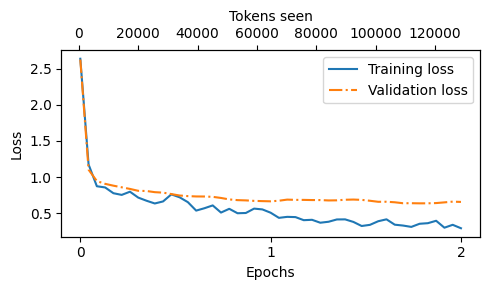

In [43]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [48]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG['context_length'], eos_id=50256)
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace('### Response:', '').strip()
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f'\nModel response:\n>> {response_text.strip()}')
    print("------------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is an cumulus (cumulus with a thin layer of air).
------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

In [47]:
len(test_data)

110

In [49]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG['context_length'], eos_id=50256, temperature=0.0)
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("### Response:","").strip()
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [00:57<00:00,  1.91it/s]


In [50]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

In [51]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [58]:
import psutil

def check_if_running(process_name):
    running =False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
    return running

ollama_running = check_if_running("ollama")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [59]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages":[
            {"role":"user", "content": prompt}
        ],
        "options":{
            "seed":123,
            "temperature":0,
            "num_ctx": 2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [60]:
model = "llama3:8b"
result = query_model("What do llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay is a staple in a llama's diet. They enjoy timothy hay, alfalfa hay, or other types of hay as a nutritious snack.
3. Grains: Llamas can eat small amounts of grains like oats, barley, or corn, but these should not make up the bulk of their diet.
4. Fruits and vegetables: Llamas might enjoy fruits and veggies as treats, such as apples, carrots, or sweet potatoes. However, it's essential to introduce these foods gradually and in moderation to avoid digestive upset.
5. Minerals: Llamas need access to mineral-rich substances like salt licks or loose minerals to ensure they're getting the necessary nutrients.

Some important notes:

* Avoid feeding llamas too many grains or sugary treats, as this can lead to digestive issues and obesity

In [65]:
prompt = ("aa" "bb")
test_json =  {"role":"user", "content": prompt}
print(test_json)

{'role': 'user', 'content': 'aabb'}


In [66]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`,"
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score."
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry['model_response'])
    print("\nScore:")
    print(">>", query_model(prompt, model))
    print("\n-------------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> A scoring task!

To evaluate the model's response, I'll compare it to the correct output and consider factors like relevance, coherence, and similarity.

**Correct output:** The car is as fast as lightning.
**Model response:** The car is as fast as a bullet.

Here's my scoring:

1. **Relevance**: Both responses are similar in meaning, comparing the car's speed to something else. (Score: 9/10)
2. **Coherence**: The model's response is coherent and easy to understand. (Score: 8/10)
3. **Similarity**: While both comparisons are fast-moving objects, lightning is a more common and intuitive simile for "very fast" than a bullet. (Score: 6/10)

**Overall score:** 23/30

To convert this score to a percentage, I'll multiply by 100:

(23/30) × 100 = **76.67%**

So, the model response scores approximately 77 out of 100. Not bad!

-------------------------------

Dataset response:


In [68]:
def generate_model_scores(json_data, json_key, model="llama3:8b"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`,"
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score:{score}")
            continue
    return scores

In [70]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores:{len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:18<00:00,  6.09it/s]

Number of scores:110 of 110
Average score: 52.38

